In [2]:
# ----------------------------------------------------------------------------
#
# TITLE - power_spectrum.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Test the 1D power spectrum calculating code using known sinusoids. Make sure the power and phase come out properly.
'''

__author__ = "James Lane"

In [53]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import importlib
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier
importlib.reload(ast1501.fourier)

<module 'ast1501.fourier' from '../../src/ast1501/fourier.py'>

In [4]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rc('font', size=12)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Meta

## Future work
- Fix darn power spectrum normalization. Maybe

## Information
- See the `ast1501.fourier` module
- Bovy RC stuff https://github.com/jobovy/apogee-rc/tree/master/py
- Check Bovy paper http://iopscience.iop.org/article/10.1088/0004-637X/800/2/83/pdf
- Ginsburg FFT stuff https://github.com/keflavich/agpy/tree/master/AG_fft_tools

# Prepare

## Functions

In [5]:
### Function definitions

# Begin test

## Understand Numpy frequency generators

Nyquist is $1/2\Delta$. $\Delta$ is the interval given the number of sample points over the spatial range you're considering. For example. If you take 10 samples over the range $[0,2\pi]$ (i.e. including the endpoint) then your delta is $(2\pi-0)/(10-1) = 2\pi/9$. Then the Nyquist frequency would be:

$
f_{c} = \frac{1}{2} \frac{9}{2\pi} = \frac{9}{4\pi}
$

First use `np.fft.fftfreq` to make the array of frequencies. The first argument is the number of samples. The second argument is $\Delta$.

It's critical to see that `fftfreq` distinguishes between an odd number of samples and an even number of samples over the same range, such that it is always symmetric. if an even number of samples is passed then the output array runs from $-f_{c} \rightarrow f_{c}$. However, if an odd number of samples is passed the array runs from a frequency larger than $-f_{c}$ to a number smaller than $f_{c}$. This keeps the arrays symmetric.

### Example

The even sampling returns the anticipated array running from $-f_{c}$ to $f_{c}$, while the odd sampling does not.

In [6]:
test_npoints = 10
test_data = np.linspace(0, 2*np.pi, num=test_npoints, endpoint=True)

print('10 spatial samples between 0 and 2pi (including the endpoint) looks like:')
print( test_data )
print('In theory the Nyquist frequency should be')
print( 0.5/np.diff(test_data)[0] )
print('\n')

print('The frequency array takes the form:')
print( np.fft.fftshift(np.fft.fftfreq( test_data.shape[0] , d=np.diff(test_data)[0] )) )
print('Which goes from -Nyquist to +Nyquist')
print('====================================')
print('\n\n')

test_npoints = 11
test_data = np.linspace(0, 2*np.pi, num=test_npoints, endpoint=True)

print('However 11 spatial samples between 0 and 2pi (including the endpoint) looks like:')
print( test_data )
print('In theory the Nyquist frequency should be')
print( 0.5/np.diff(test_data)[0] )
print('\n')

print('The frequency array takes the form:')
print( np.fft.fftshift(np.fft.fftfreq( test_data.shape[0] , d=np.diff(test_data)[0] )) )
print('Which goes from slightly above -Nyquist to slightly below +Nyquist')
print('====================================')

# xs = np.linspace(0,2*np.pi,11)
# fs = np.fft.fftshift(np.fft.fftfreq(11,2*np.pi/11)) 
# amp = np.sin(xs)

# afs = fs[int(len(fs)/2):]

# ft = np.fft.fftshift(np.fft.fft(amp))

# ret = np.abs(ft)**2. + np.abs(ft[::-1])**2.
# aret = ret[int(len(ret)/2):]

# print(afs)
# print(aret)

10 spatial samples between 0 and 2pi (including the endpoint) looks like:
[0.         0.6981317  1.3962634  2.0943951  2.7925268  3.4906585
 4.1887902  4.88692191 5.58505361 6.28318531]
In theory the Nyquist frequency should be
0.716197243913529


The frequency array takes the form:
[-0.71619724 -0.5729578  -0.42971835 -0.2864789  -0.14323945  0.
  0.14323945  0.2864789   0.42971835  0.5729578 ]
Which goes from -Nyquist to +Nyquist



However 11 spatial samples between 0 and 2pi (including the endpoint) looks like:
[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972 5.02654825 5.65486678 6.28318531]
In theory the Nyquist frequency should be
0.7957747154594768


The frequency array takes the form:
[-0.72343156 -0.57874525 -0.43405894 -0.28937262 -0.14468631  0.
  0.14468631  0.28937262  0.43405894  0.57874525  0.72343156]
Which goes from slightly above -Nyquist to slightly below +Nyquist


In [7]:
# xs = np.linspace(0,2*np.pi,11)
# fs = np.fft.fftshift(np.fft.fftfreq(11,2*np.pi/11)) 
# amp = np.sin(xs)

# afs = fs[int(len(fs)/2):]

# ft = np.fft.fftshift(np.fft.fft(amp))

# ret = np.abs(ft)**2. + np.abs(ft[::-1])**2.
# aret = ret[int(len(ret)/2):]

# print(afs)
# print(aret)

## Setup test sinusoids

Our sinusoid function takes the form:

$f(x) = A \sin ( 2 \pi f x )$ 

Declare the function and make some tests

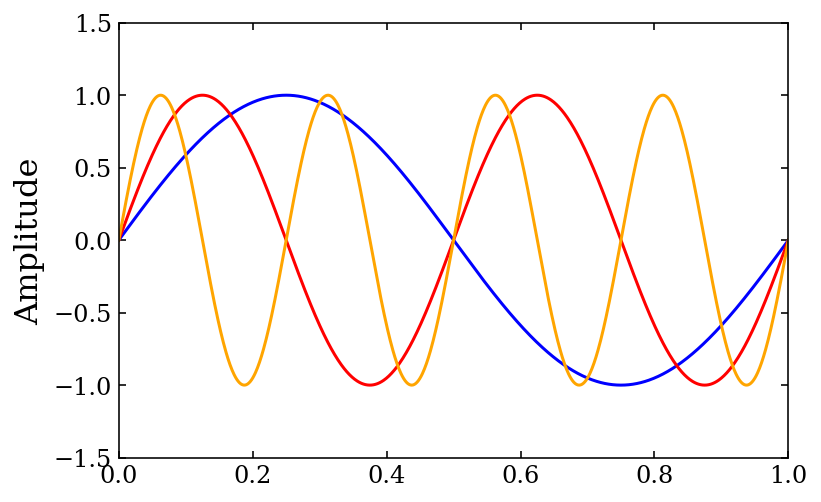

In [8]:
def sinusoid(t,A,f):
    return A*np.sin(2*np.pi*t*f)
#def

fig = plt.figure()
ax = fig.add_subplot(111)

test_data = np.linspace(0,1,num=1000)
ax.plot( test_data, sinusoid(test_data,1,1), color='Blue' )
ax.plot( test_data, sinusoid(test_data,1,2), color='Red' )
ax.plot( test_data, sinusoid(test_data,1,4), color='Orange' )

ax.set_xlim(0,1)
ax.set_ylim(-1.5,1.5)
ax.set_xlabel('')
ax.set_ylabel('Amplitude')

plt.show()

## Test periodogram functions

The power of a sinusoid should be its amplitude divided by the square root of 2. Let's make sure we can recover that.

$P = \frac{ A^{2} }{ 2 }$

In [ ]:
import importlib
importlib.reload(ast1501.fourier)

test_a = np.array([4,])
test_f = np.array([2,])

test_num = 12
test_data = np.linspace(0, 1, num=test_num, endpoint=True)
test_bin_size = np.diff(test_data)[0]
test_amp = np.zeros_like(test_data)
for j in range(len(test_a)):
    test_amp += sinusoid(test_data,test_a[j],test_f[j])
###j

ks, pk, phase = ast1501.fourier.psd(test_amp, test_bin_size, pad=False, return_phase=True)

ind_ks_pos = int(1+len(ks)/2)
ks_pos = np.abs( ks[:ind_ks_pos] )
pk_pos = pk[:ind_ks_pos]
phase_pos = phase[:ind_ks_pos]

print('Frequencies are:')
print(ks_pos)
print('Power is')
print(pk_pos)

# Plot
fig = plt.figure( figsize=(15,5) )
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3)

ax1.plot(test_data, test_amp, color='Black', marker='o')
ax1.set_xlabel(r'$\Phi$')
ax1.set_ylabel(r'Amplitude')

ax2.plot(ks_pos, pk_pos, color='Black', marker='o')
ax2.set_xlabel(r'$k$')
ax2.set_ylabel('Power')

plt.show()
plt.close('all')

# Print power

print('Total power is:')
print(np.sum( pk_pos ) )
print('Total power should be the sum of:')
print(test_a**2/2)

pass;

> /Users/JamesLane/Science/Projects/PhD/AST1501/src/ast1501/fourier.py(65)psd()
-> if pad:
(Pdb) int(len(arr)/2)
6
(Pdb) ret
array([ 14.13036305,  19.37101491,  50.2069602 , 500.95729373,
       466.9667818 ,   4.3675863 ,   4.3675863 , 466.9667818 ,
       500.95729373,  50.2069602 ,  19.37101491,  14.13036305])
(Pdb) np.fft.fftshift(np.fft.fftfreq(n,dx))
array([-5.5       , -4.58333333, -3.66666667, -2.75      , -1.83333333,
       -0.91666667,  0.        ,  0.91666667,  1.83333333,  2.75      ,
        3.66666667,  4.58333333])
(Pdb) arr_fft
array([-2.57064391e+00 +0.j        , -2.64920068e+00 -0.70985118j,
       -2.98104788e+00 -1.7211088j , -4.37938913e+00 -4.37938913j,
        1.07540596e+01+18.62657769j,  5.40899996e-01 +2.01866627j,
       -3.10862447e-15 +0.j        ,  5.40899996e-01 -2.01866627j,
        1.07540596e+01-18.62657769j, -4.37938913e+00 +4.37938913j,
       -2.98104788e+00 +1.7211088j , -2.64920068e+00 +0.70985118j])
(Pdb) arr_fft
array([-2.57064391e+00 +0.j     

The function in `fourier.py` behaves properly. The factor of 2 has been removed from the return statement such that the sum of the returned power terms is equal to the mean-squared-amplitude (MSA) of the input signal. The root-mean-squared-amplitude (RMSA) for a sine wave is equal to:

$
A_{RMS} = \frac{ A }{ \sqrt{2} }
$

Therefore the MSA for a sine wave is:

$
A_{MSA} = \frac{ A^{2} }{ 2 }
$



***

## Examine power returned as a function of the number of samples

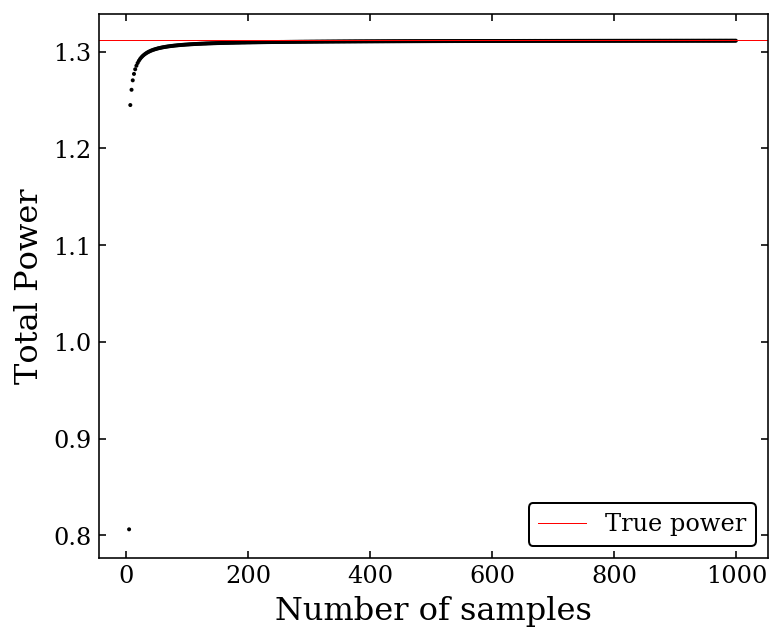

In [21]:
n_samples = np.arange(5,1001,2)

test_a = np.array([4,5])
test_f = np.array([1,2])

# Plot
fig = plt.figure( figsize=(6,5) )
ax = fig.add_subplot(111)

for i in range(len(n_samples)):
    
    test_num = n_samples[i]
    test_data = np.linspace(0, 1, num=test_num, endpoint=True)
    test_bin_size = np.diff(test_data)[0]
    test_amp = np.zeros_like(test_data)
    for j in range(len(test_a)):
        test_amp += sinusoid(test_data,test_a[j],test_f[j])
    ###j

    ks, pk = ast1501.fourier.psd(test_amp, test_bin_size, pad=False, return_phase=False)

    ind_ks_pos = int(1+len(ks)/2)
    ks_pos = np.abs( ks[:ind_ks_pos] )
    pk_pos = pk[:ind_ks_pos]
    
    total_power = np.sum(pk_pos/2)

    ax.scatter(test_num, np.log10(total_power), facecolor='Black', edgecolor='None', marker='o', s=4)
    ax.set_xlabel(r'Number of samples')
    ax.set_ylabel('Total Power')
    fig.suptitle('No Padding')
###i
    
ax.axhline(np.log10( np.sum( np.square( test_a )/2 ) ), linewidth=0.5, color='Red', label='True power')
ax.legend()
    
plt.show()
plt.close('all')
pass;

## Now use padding

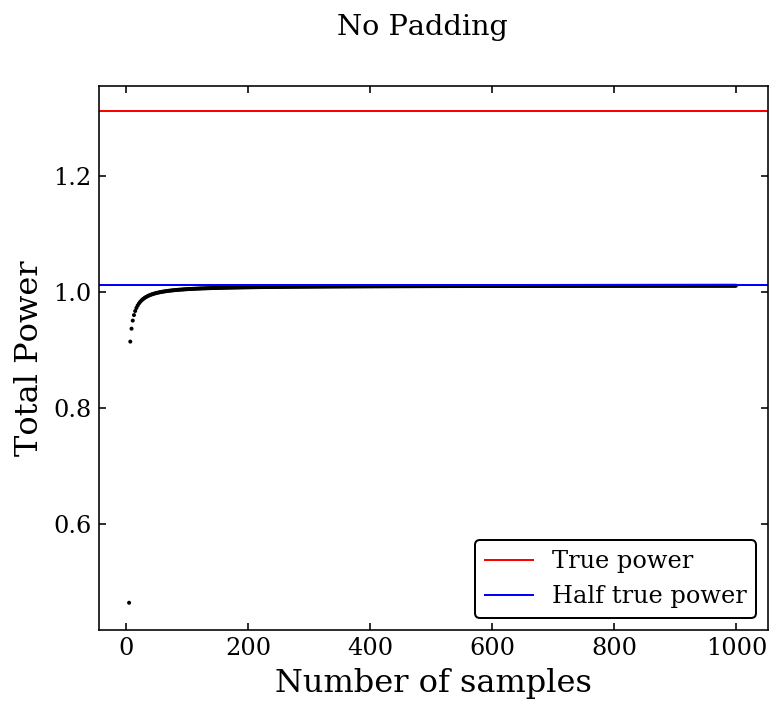

In [30]:
n_samples = np.arange(5,1001,2)

test_a = np.array([4,5])
test_f = np.array([1,2])

# Plot
fig = plt.figure( figsize=(6,5) )
ax = fig.add_subplot(111)

for i in range(len(n_samples)):
    
    test_num = n_samples[i]
    test_data = np.linspace(0, 1, num=test_num, endpoint=True)
    test_bin_size = np.diff(test_data)[0]
    test_amp = np.zeros_like(test_data)
    for j in range(len(test_a)):
        test_amp += sinusoid(test_data,test_a[j],test_f[j])
    ###j

    ks, pk = ast1501.fourier.psd(test_amp, test_bin_size, pad=True, return_phase=False)

    ind_ks_pos = int(1+len(ks)/2)
    ks_pos = np.abs( ks[:ind_ks_pos] )
    pk_pos = pk[:ind_ks_pos]
    
    total_power = np.sum(pk_pos/2)

    ax.scatter(test_num, np.log10(total_power), facecolor='Black', edgecolor='None', marker='o', s=4)
    ax.set_xlabel(r'Number of samples')
    ax.set_ylabel('Total Power')
    fig.suptitle('No Padding')
###i
    
ax.axhline(np.log10( np.sum( np.square( test_a )/2 ) ), linewidth=1, color='Red', label='True power')
ax.axhline(np.log10( np.sum( np.square( test_a )/2 )/2 ), linewidth=1, color='Blue', label='Half true power')
ax.legend()
    
plt.show()
plt.close('all')
pass;